### Data Dictionary

In this notebook, to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Identification Patient|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

from tpot import TPOTClassifier, TPOTRegressor
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Data Exploration

In [2]:
df = pd.read_csv("cell_samples.csv")

In [3]:
df

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           699 non-null    int64 
 1   Clump        699 non-null    int64 
 2   UnifSize     699 non-null    int64 
 3   UnifShape    699 non-null    int64 
 4   MargAdh      699 non-null    int64 
 5   SingEpiSize  699 non-null    int64 
 6   BareNuc      699 non-null    object
 7   BlandChrom   699 non-null    int64 
 8   NormNucl     699 non-null    int64 
 9   Mit          699 non-null    int64 
 10  Class        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [5]:
df.describe(include='all')

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699,699.000000,699.000000,699.000000,699.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,402,NaN,NaN,NaN,NaN
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,NaN,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,NaN,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,NaN,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,NaN,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,NaN,5.000000,4.000000,1.000000,4.000000


In [6]:
df.shape

(699, 11)

In [7]:
df.columns

Index(['ID', 'Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BareNuc', 'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

### Data Visualization

### Univariate Data Exploration

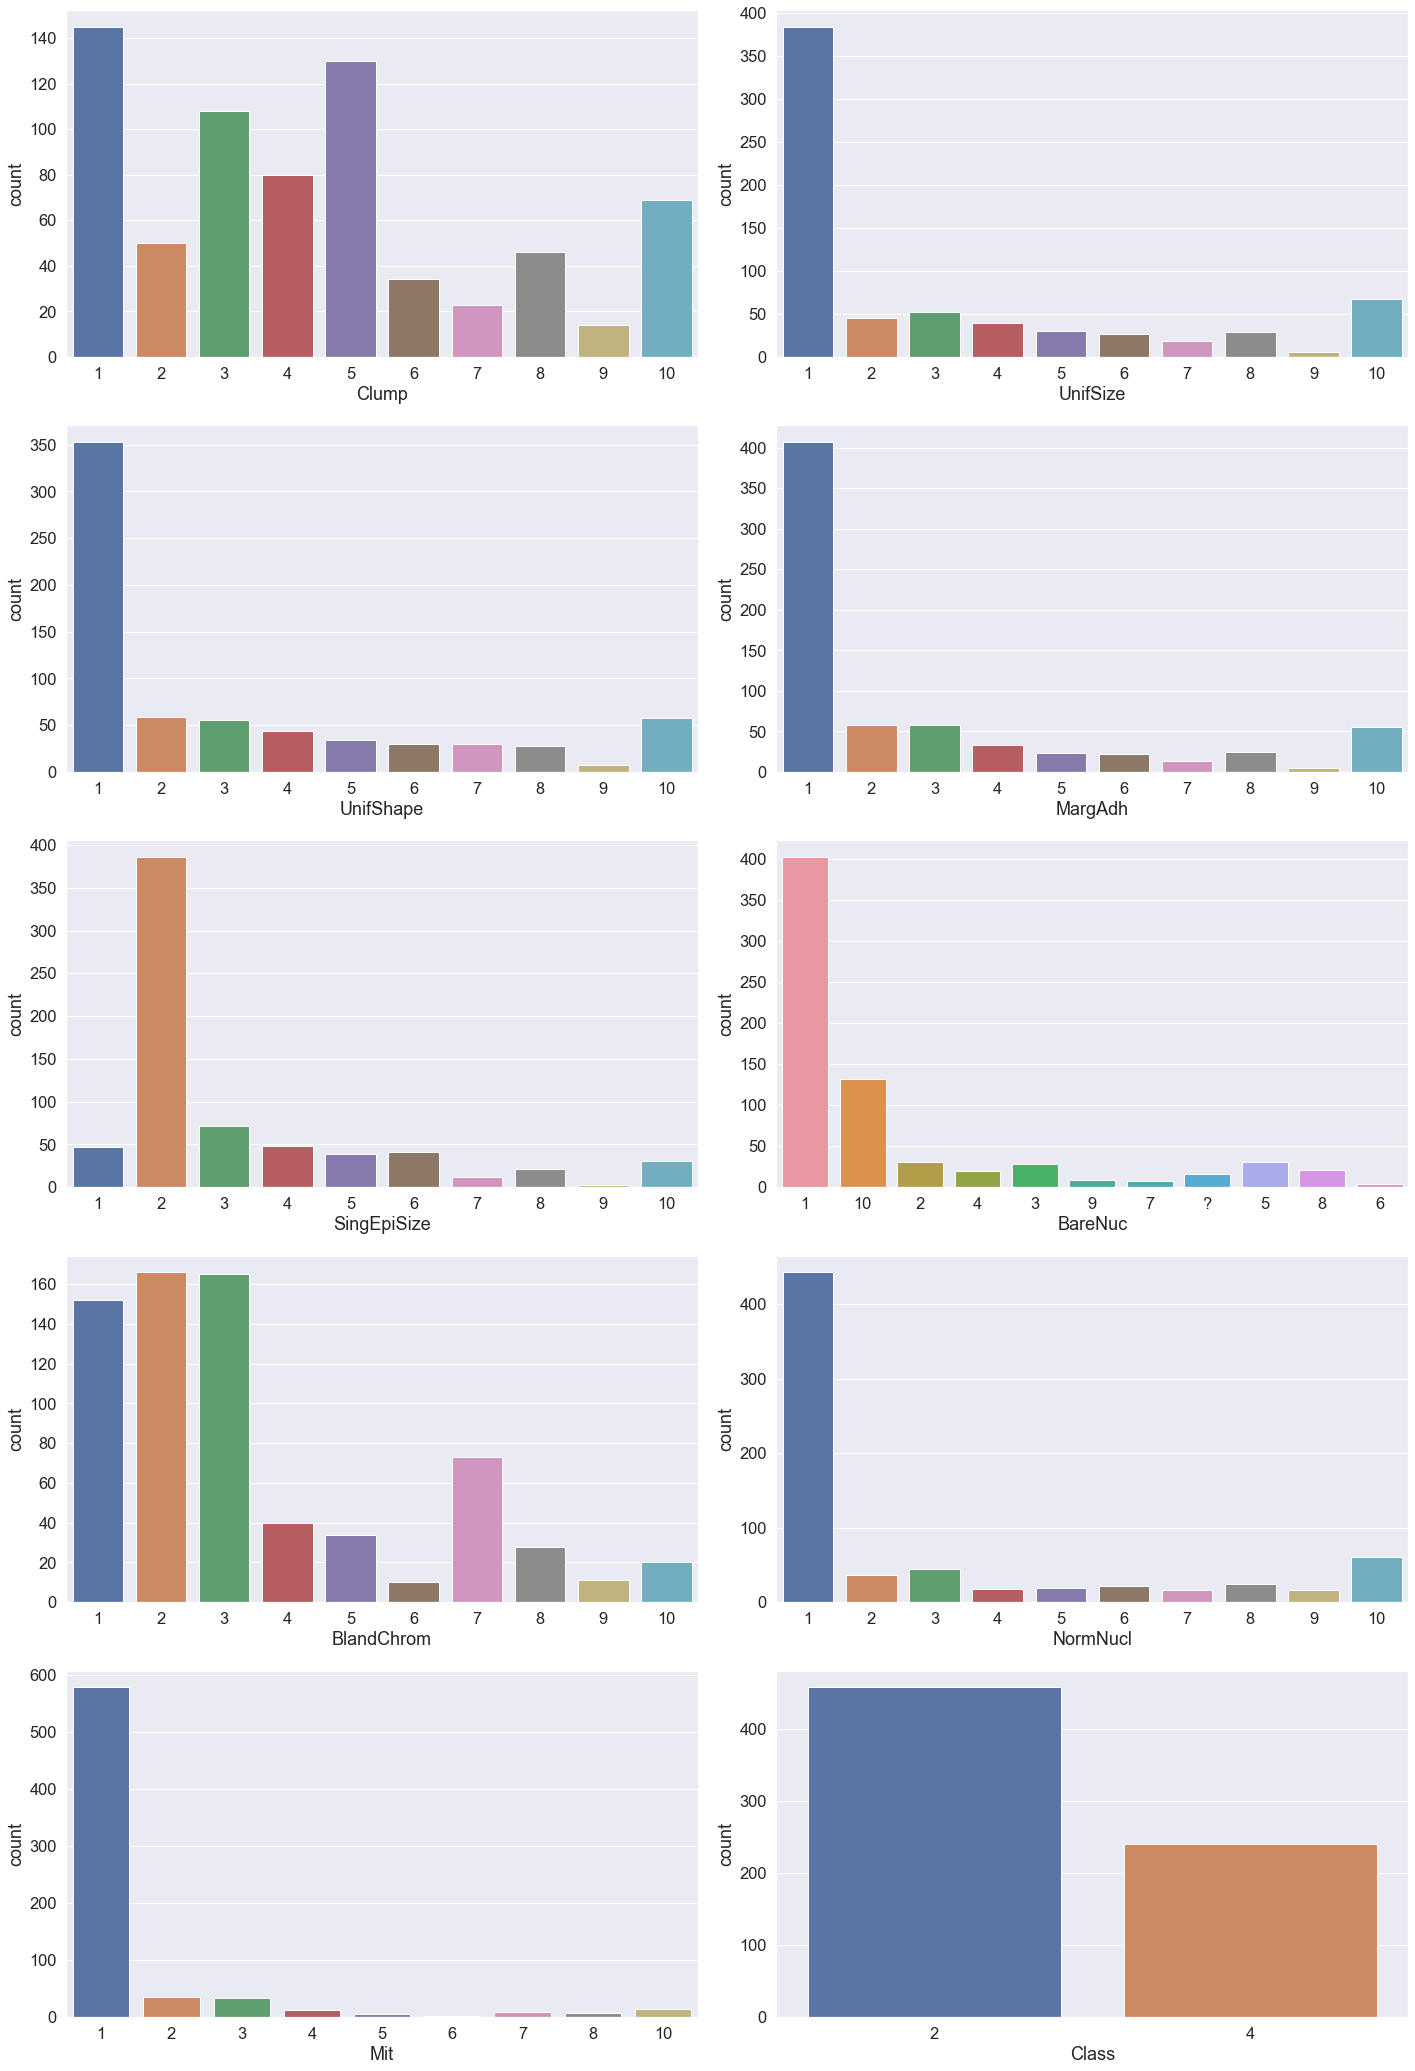

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.Clump)
plt.subplot(7,2,2)
sns.countplot(df.UnifSize)
plt.subplot(7,2,3)
sns.countplot(df.UnifShape)
plt.subplot(7,2,4)
sns.countplot(df.MargAdh)
plt.subplot(7,2,5)
sns.countplot(df.SingEpiSize)
plt.subplot(7,2,6)
sns.countplot(df.BareNuc)
plt.subplot(7,2,7)
sns.countplot(df.BlandChrom)
plt.subplot(7,2,8)
sns.countplot(df.NormNucl)
plt.subplot(7,2,9)
sns.countplot(df.Mit)
plt.subplot(7,2,10)
sns.countplot(df.Class)
# plt.subplot(7,2,11)
# sns.countplot()
# plt.subplot(7,2,12)
# sns.countplot()
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

In [9]:
df.corr()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,Class
ID,1.000000,-0.055308,-0.041603,-0.041576,-0.064878,-0.045528,-0.060051,-0.052072,-0.034901,-0.080226
Clump,-0.055308,1.000000,0.644913,0.654589,0.486356,0.521816,0.558428,0.535835,0.350034,0.716001
UnifSize,-0.041603,0.644913,1.000000,0.906882,0.705582,0.751799,0.755721,0.722865,0.458693,0.817904
UnifShape,-0.041576,0.654589,0.906882,1.000000,0.683079,0.719668,0.735948,0.719446,0.438911,0.818934
MargAdh,-0.064878,0.486356,0.705582,0.683079,1.000000,0.599599,0.666715,0.603352,0.417633,0.696800
SingEpiSize,-0.045528,0.521816,0.751799,0.719668,0.599599,1.000000,0.616102,0.628881,0.479101,0.682785
BlandChrom,-0.060051,0.558428,0.755721,0.735948,0.666715,0.616102,1.000000,0.665878,0.344169,0.756616
NormNucl,-0.052072,0.535835,0.722865,0.719446,0.603352,0.628881,0.665878,1.000000,0.428336,0.712244
Mit,-0.034901,0.350034,0.458693,0.438911,0.417633,0.479101,0.344169,0.428336,1.000000,0.423170
Class,-0.080226,0.716001,0.817904,0.818934,0.696800,0.682785,0.756616,0.712244,0.423170,1.000000


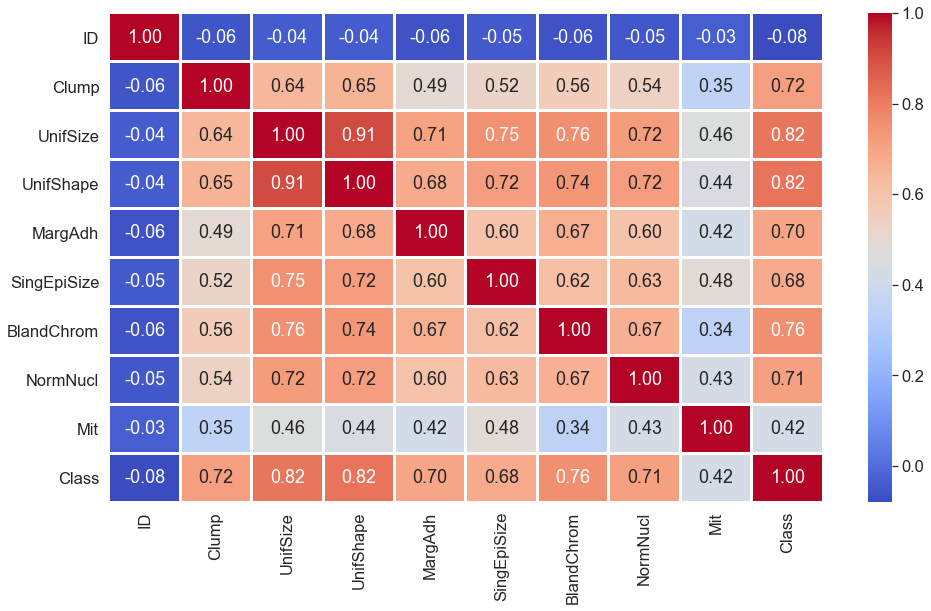

In [10]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

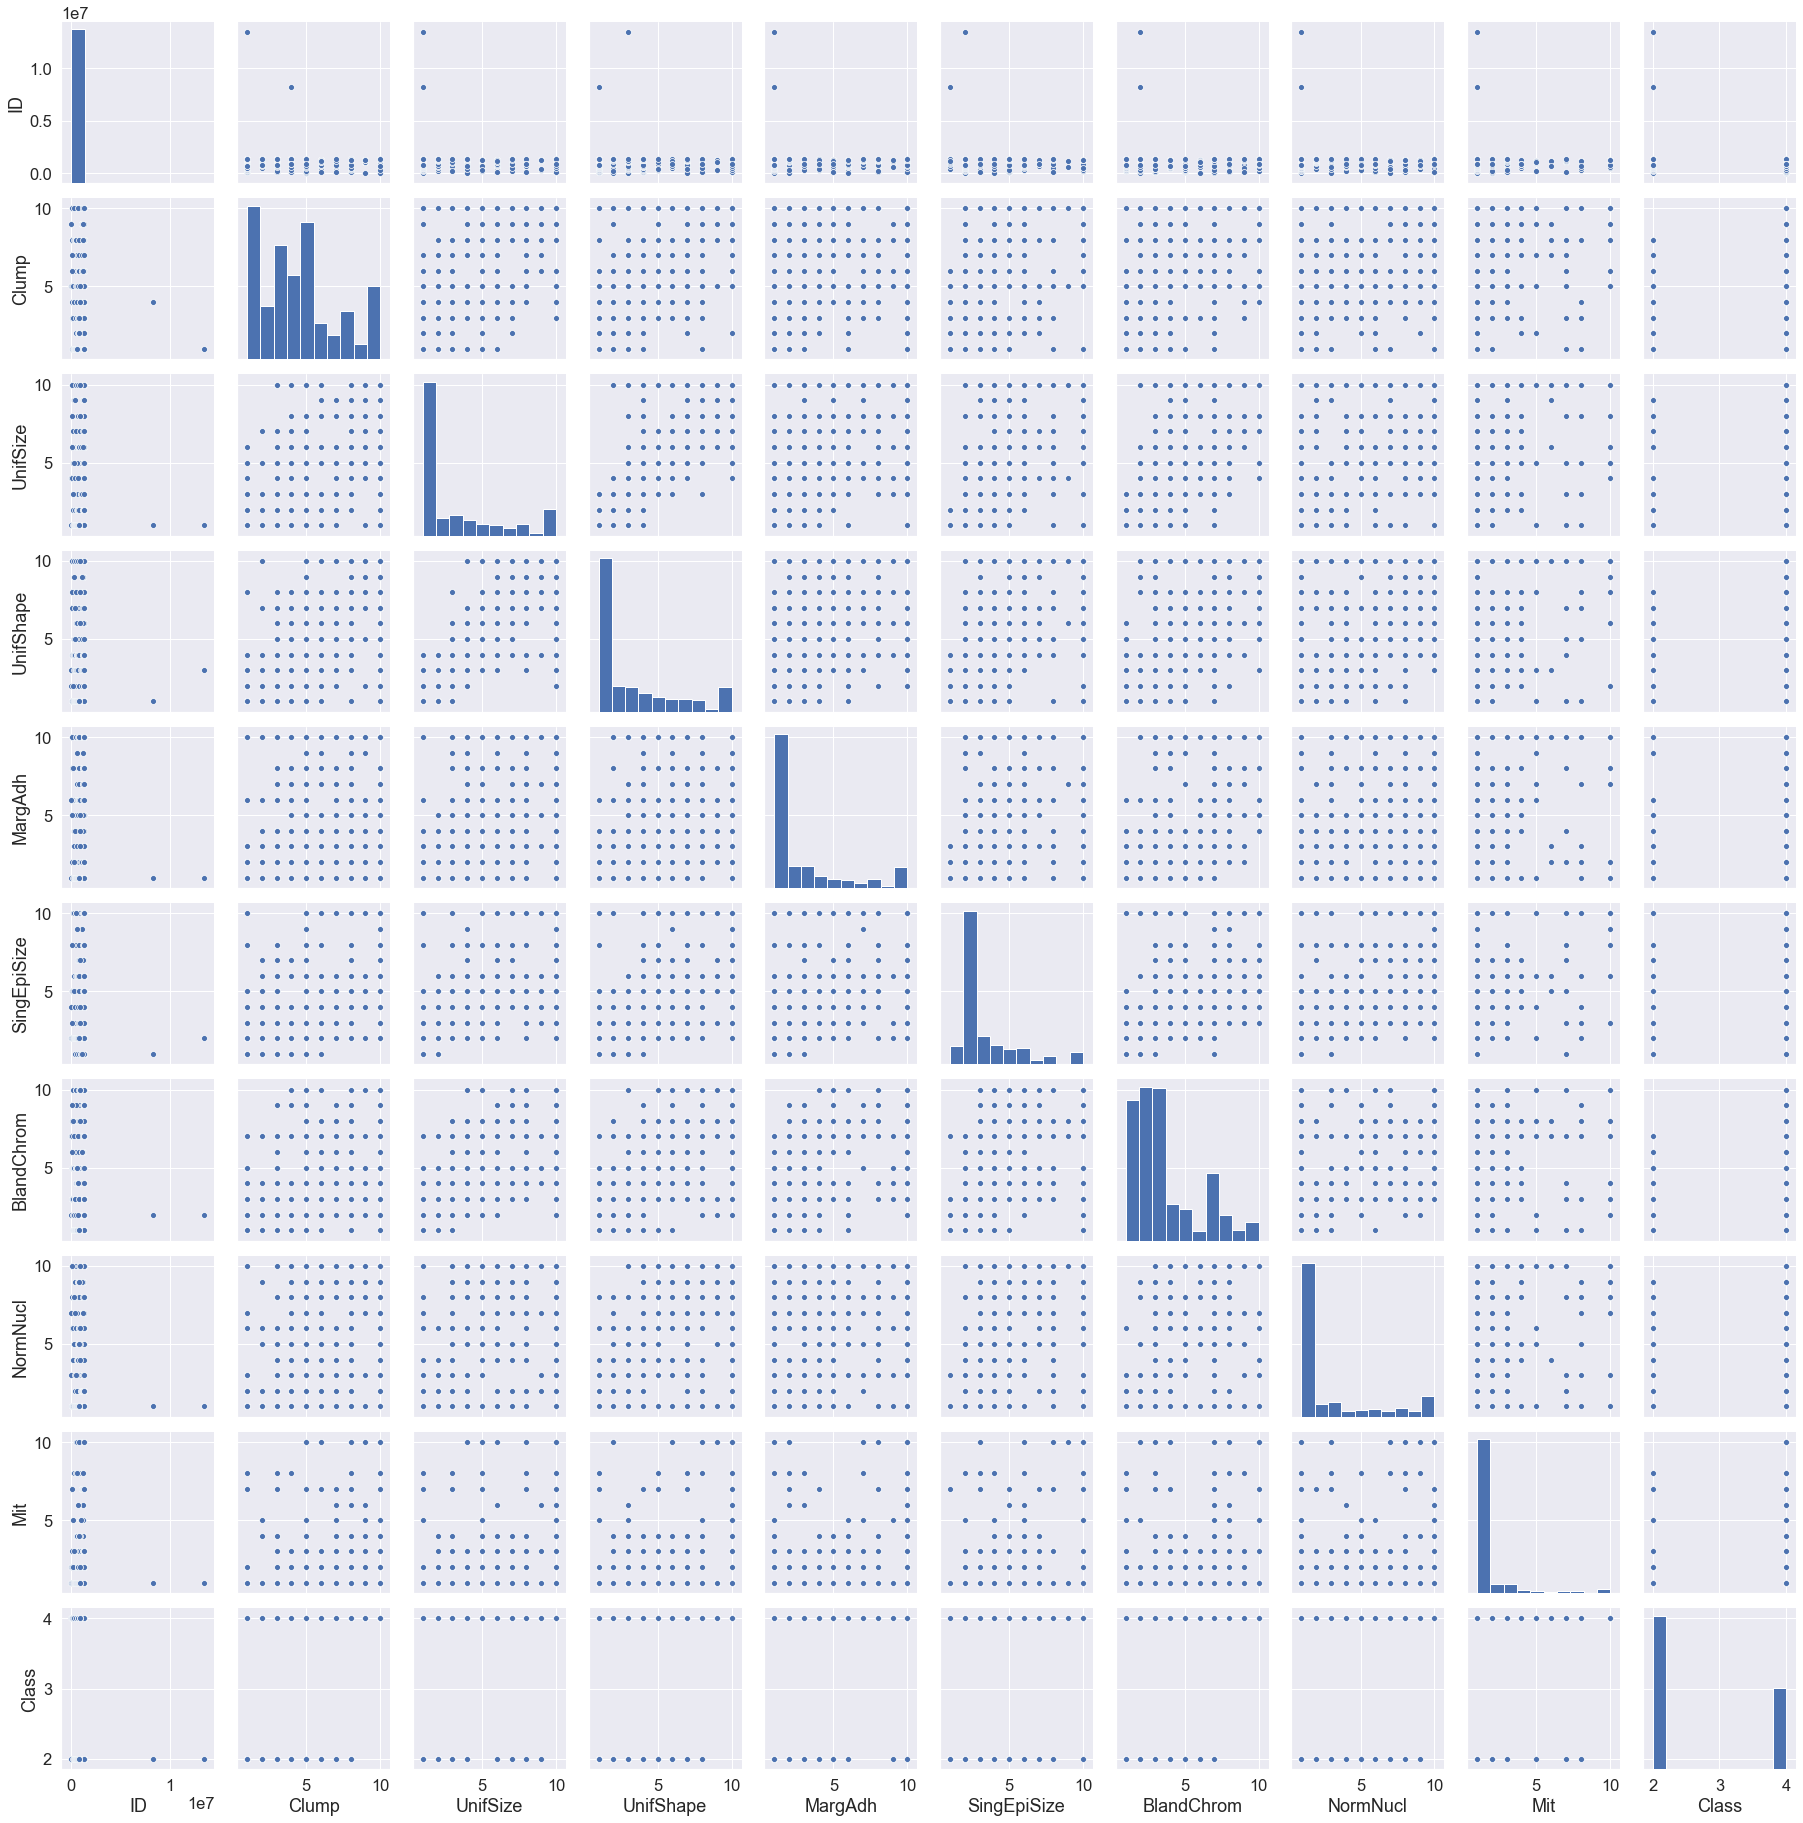

In [11]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [12]:
df.isnull().sum()

ID             0
Clump          0
UnifSize       0
UnifShape      0
MargAdh        0
SingEpiSize    0
BareNuc        0
BlandChrom     0
NormNucl       0
Mit            0
Class          0
dtype: int64

### Treat Duplicate Values

In [13]:
df.duplicated(keep='first').sum()

8

In [14]:
df[df.duplicated(keep=False)]

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
42,1100524,6,10,10,2,8,10,7,3,3,4
62,1116116,9,10,10,1,10,8,3,3,1,4
168,1198641,3,1,1,1,2,1,3,1,1,2
207,1218860,1,1,1,1,1,1,3,1,1,2
208,1218860,1,1,1,1,1,1,3,1,1,2
253,1100524,6,10,10,2,8,10,7,3,3,4
254,1116116,9,10,10,1,10,8,3,3,1,4
258,1198641,3,1,1,1,2,1,3,1,1,2
267,320675,3,3,5,2,3,10,7,1,1,4
272,320675,3,3,5,2,3,10,7,1,1,4


In [15]:
df.drop_duplicates(ignore_index=True, inplace=True)

In [16]:
df

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
686,776715,3,1,1,1,3,2,1,1,1,2
687,841769,2,1,1,1,2,1,1,1,1,2
688,888820,5,10,10,3,7,3,8,10,2,4
689,897471,4,8,6,4,3,4,10,6,1,4


### Treat Outliers

### Treat Data Types

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           691 non-null    int64 
 1   Clump        691 non-null    int64 
 2   UnifSize     691 non-null    int64 
 3   UnifShape    691 non-null    int64 
 4   MargAdh      691 non-null    int64 
 5   SingEpiSize  691 non-null    int64 
 6   BareNuc      691 non-null    object
 7   BlandChrom   691 non-null    int64 
 8   NormNucl     691 non-null    int64 
 9   Mit          691 non-null    int64 
 10  Class        691 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 59.5+ KB


In [18]:
df['BareNuc'].value_counts()

1     397
10    130
5      30
2      30
3      28
8      20
4      19
?      16
9       9
7       8
6       4
Name: BareNuc, dtype: int64

In [19]:
df['BareNuc'].replace(to_replace='?',value=6,inplace=True)

In [20]:
df['BareNuc'].value_counts()

1     397
10    130
5      30
2      30
3      28
8      20
4      19
6      16
9       9
7       8
6       4
Name: BareNuc, dtype: int64

In [21]:
encoder = LabelEncoder()

In [22]:
df['Class'] = encoder.fit_transform(df['Class'])

In [23]:
df['Class'].value_counts()

0    453
1    238
Name: Class, dtype: int64

In [24]:
df

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
686,776715,3,1,1,1,3,2,1,1,1,0
687,841769,2,1,1,1,2,1,1,1,1,0
688,888820,5,10,10,3,7,3,8,10,2,1
689,897471,4,8,6,4,3,4,10,6,1,1


### Drop unwanted features

In [25]:
df.columns

Index(['ID', 'Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BareNuc', 'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

In [26]:
df.drop(['ID'],axis=1,inplace=True)

In [27]:
df

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
686,3,1,1,1,3,2,1,1,1,0
687,2,1,1,1,2,1,1,1,1,0
688,5,10,10,3,7,3,8,10,2,1
689,4,8,6,4,3,4,10,6,1,1


In [28]:
df2 = pd.get_dummies(df,columns=['BareNuc'],drop_first=True)

In [29]:
df2

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,Class,BareNuc_1,BareNuc_10,BareNuc_2,BareNuc_3,BareNuc_4,BareNuc_5,BareNuc_6,BareNuc_7,BareNuc_8,BareNuc_9
0,5,1,1,1,2,3,1,1,0,1,0,0,0,0,0,0,0,0,0
1,5,4,4,5,7,3,2,1,0,0,1,0,0,0,0,0,0,0,0
2,3,1,1,1,2,3,1,1,0,0,0,1,0,0,0,0,0,0,0
3,6,8,8,1,3,3,7,1,0,0,0,0,0,1,0,0,0,0,0
4,4,1,1,3,2,3,1,1,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,3,1,1,1,3,1,1,1,0,0,0,1,0,0,0,0,0,0,0
687,2,1,1,1,2,1,1,1,0,1,0,0,0,0,0,0,0,0,0
688,5,10,10,3,7,8,10,2,1,0,0,0,1,0,0,0,0,0,0
689,4,8,6,4,3,10,6,1,1,0,0,0,0,1,0,0,0,0,0


In [30]:
df2.columns

Index(['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BlandChrom', 'NormNucl', 'Mit', 'Class', 'BareNuc_1', 'BareNuc_10',
       'BareNuc_2', 'BareNuc_3', 'BareNuc_4', 'BareNuc_5', 'BareNuc_6',
       'BareNuc_7', 'BareNuc_8', 'BareNuc_9'],
      dtype='object')

In [31]:
df2 = df2[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize','BlandChrom', 'NormNucl', 'Mit',
         'BareNuc_1', 'BareNuc_10','BareNuc_2', 'BareNuc_3', 'BareNuc_4', 'BareNuc_5', 'BareNuc_6',
       'BareNuc_7', 'BareNuc_8', 'BareNuc_9', 'Class']]

In [32]:
df2

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,BareNuc_1,BareNuc_10,BareNuc_2,BareNuc_3,BareNuc_4,BareNuc_5,BareNuc_6,BareNuc_7,BareNuc_8,BareNuc_9,Class
0,5,1,1,1,2,3,1,1,1,0,0,0,0,0,0,0,0,0,0
1,5,4,4,5,7,3,2,1,0,1,0,0,0,0,0,0,0,0,0
2,3,1,1,1,2,3,1,1,0,0,1,0,0,0,0,0,0,0,0
3,6,8,8,1,3,3,7,1,0,0,0,0,1,0,0,0,0,0,0
4,4,1,1,3,2,3,1,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,3,1,1,1,3,1,1,1,0,0,1,0,0,0,0,0,0,0,0
687,2,1,1,1,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0
688,5,10,10,3,7,8,10,2,0,0,0,1,0,0,0,0,0,0,1
689,4,8,6,4,3,10,6,1,0,0,0,0,1,0,0,0,0,0,1


### Create and save processed dataset

In [33]:
#df2.to_csv("celltrain.csv",index=False)

### Train Test Split

In [34]:
df2.shape

(691, 19)

In [35]:
X = df2.iloc[:,0:18]
y = df2.iloc[:,18]

### Treat Imbalance Data

In [36]:
y.value_counts()

0    453
1    238
Name: Class, dtype: int64

In [37]:
ros = RandomOverSampler(sampling_strategy='all',random_state=0)

In [38]:
new_X, new_y = ros.fit_resample(X, y)

In [39]:
new_y.value_counts()

1    453
0    453
Name: Class, dtype: int64

In [40]:
new_X

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,BareNuc_1,BareNuc_10,BareNuc_2,BareNuc_3,BareNuc_4,BareNuc_5,BareNuc_6,BareNuc_7,BareNuc_8,BareNuc_9
0,5,1,1,1,2,3,1,1,1,0,0,0,0,0,0,0,0,0
1,5,4,4,5,7,3,2,1,0,1,0,0,0,0,0,0,0,0
2,3,1,1,1,2,3,1,1,0,0,1,0,0,0,0,0,0,0
3,6,8,8,1,3,3,7,1,0,0,0,0,1,0,0,0,0,0
4,4,1,1,3,2,3,1,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,6,10,10,2,8,7,3,3,0,1,0,0,0,0,0,0,0,0
902,7,5,6,3,3,7,4,1,0,0,0,0,0,0,0,0,1,0
903,10,7,7,6,4,4,1,2,0,1,0,0,0,0,0,0,0,0
904,6,6,7,10,3,8,10,2,0,1,0,0,0,0,0,0,0,0


In [41]:
new_X.values, new_y.values

(array([[ 5,  1,  1, ...,  0,  0,  0],
        [ 5,  4,  4, ...,  0,  0,  0],
        [ 3,  1,  1, ...,  0,  0,  0],
        ...,
        [10,  7,  7, ...,  0,  0,  0],
        [ 6,  6,  7, ...,  0,  0,  0],
        [ 4,  8,  8, ...,  0,  0,  0]], dtype=int64),
 array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0

In [42]:
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=0)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((724, 18), (182, 18), (724,), (182,))

### Feature Scaling

In [44]:
X_train

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,BareNuc_1,BareNuc_10,BareNuc_2,BareNuc_3,BareNuc_4,BareNuc_5,BareNuc_6,BareNuc_7,BareNuc_8,BareNuc_9
372,3,1,1,4,3,2,2,1,1,0,0,0,0,0,0,0,0,0
304,3,1,1,1,2,5,1,1,0,0,0,0,0,1,0,0,0,0
523,4,1,1,1,1,2,1,1,1,0,0,0,0,0,0,0,0,0
85,5,10,6,1,10,4,10,10,0,0,0,0,1,0,0,0,0,0
501,1,1,1,1,2,1,1,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,7,5,6,10,5,7,9,4,0,1,0,0,0,0,0,0,0,0
192,5,1,1,1,2,2,1,1,1,0,0,0,0,0,0,0,0,0
629,10,10,7,8,7,10,10,3,1,0,0,0,0,0,0,0,0,0
559,3,1,2,1,2,3,1,1,1,0,0,0,0,0,0,0,0,0


In [45]:
minmax = MinMaxScaler()

In [46]:
X_train_scaled = minmax.fit_transform(X_train)

In [47]:
X_test_scaled = minmax.transform(X_test)

In [48]:
X_train_scaled

array([[0.22222222, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.22222222, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 1.        , 0.66666667, ..., 0.        , 0.        ,
        0.        ],
       [0.22222222, 0.        , 0.11111111, ..., 0.        , 0.        ,
        0.        ],
       [0.22222222, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [49]:
X_test_scaled

array([[0.55555556, 0.22222222, 0.22222222, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.55555556, 0.55555556, ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.22222222, 1.        , 0.22222222, ..., 0.        , 0.        ,
        0.        ],
       [0.22222222, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.11111111, 0.22222222, 0.11111111, ..., 0.        , 0.        ,
        0.        ]])

### Model Training

### Using XGBoost (Scikit-Learn)

In [50]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=100, objective='binary:logistic')

In [51]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='error',early_stopping_rounds=10)

[0]	validation_0-error:0.049451
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.065934
[2]	validation_0-error:0.065934
[3]	validation_0-error:0.065934
[4]	validation_0-error:0.06044
[5]	validation_0-error:0.06044
[6]	validation_0-error:0.06044
[7]	validation_0-error:0.06044
[8]	validation_0-error:0.043956
[9]	validation_0-error:0.049451
[10]	validation_0-error:0.049451
[11]	validation_0-error:0.049451
[12]	validation_0-error:0.043956
[13]	validation_0-error:0.043956
[14]	validation_0-error:0.038462
[15]	validation_0-error:0.038462
[16]	validation_0-error:0.038462
[17]	validation_0-error:0.038462
[18]	validation_0-error:0.038462
[19]	validation_0-error:0.038462
[20]	validation_0-error:0.038462
[21]	validation_0-error:0.038462
[22]	validation_0-error:0.038462
[23]	validation_0-error:0.038462
[24]	validation_0-error:0.038462
Stopping. Best iteration:
[14]	validation_0-error:0.038462



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [52]:
y_pred = xgbmodel.predict(X_test_scaled)

In [53]:
y_pred

array([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0], dtype=int64)

### Model Evaluation

In [54]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[88,  5],
       [ 2, 87]], dtype=int64)

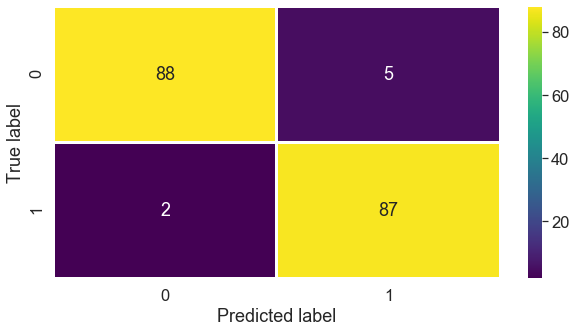

In [55]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

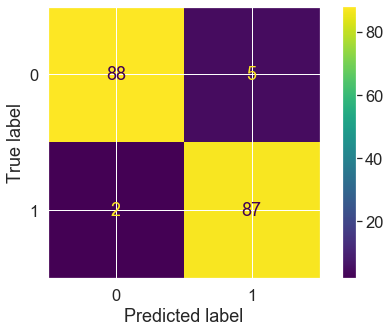

In [56]:
fig , ax = plt.subplots(figsize=(8,5))
plot_confusion_matrix(xgbmodel,X_test_scaled,y_test,values_format='.4g',ax=ax)
plt.show()

In [57]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        93
           1       0.95      0.98      0.96        89

    accuracy                           0.96       182
   macro avg       0.96      0.96      0.96       182
weighted avg       0.96      0.96      0.96       182



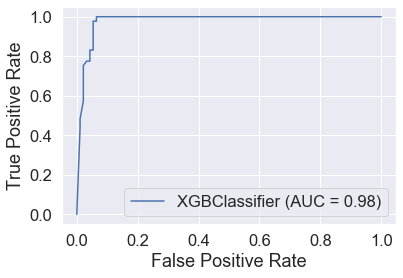

In [58]:
plot_roc_curve(xgbmodel,X_test_scaled,y_test)
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [59]:
X.columns

Index(['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BlandChrom', 'NormNucl', 'Mit', 'BareNuc_1', 'BareNuc_10', 'BareNuc_2',
       'BareNuc_3', 'BareNuc_4', 'BareNuc_5', 'BareNuc_6', 'BareNuc_7',
       'BareNuc_8', 'BareNuc_9'],
      dtype='object')

In [60]:
xgbmodel.get_booster().feature_names = ['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BlandChrom', 'NormNucl', 'Mit', 'BareNuc_1', 'BareNuc_10', 'BareNuc_2',
       'BareNuc_3', 'BareNuc_4', 'BareNuc_5', 'BareNuc_6', 'BareNuc_7',
       'BareNuc_8', 'BareNuc_9']

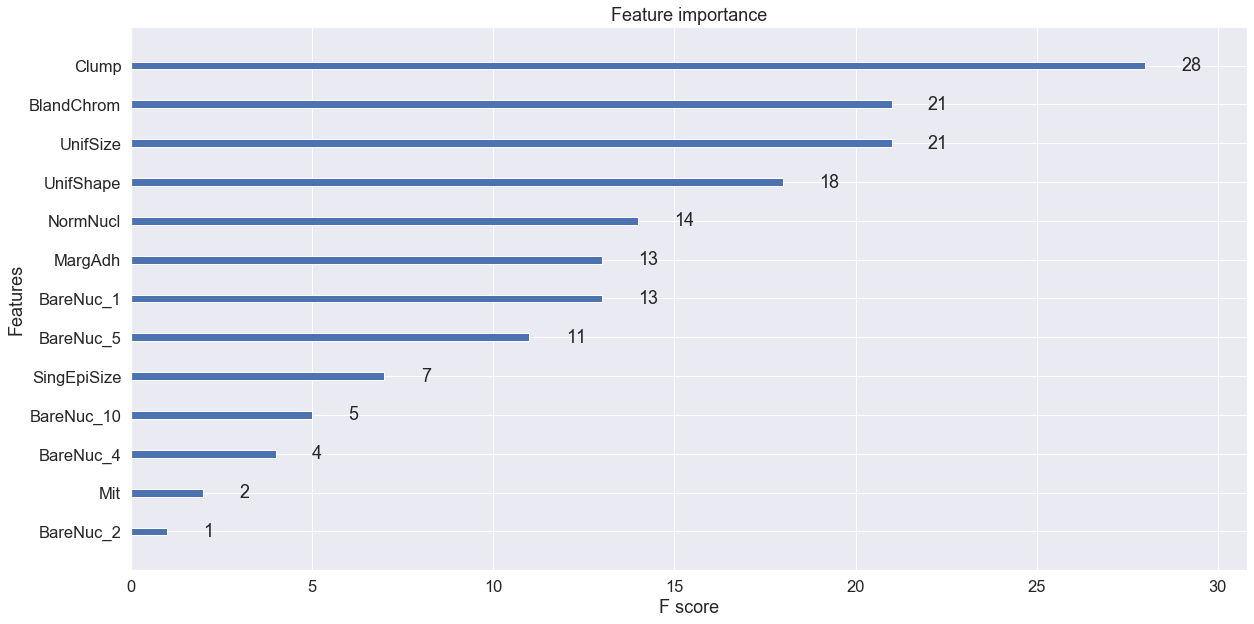

In [61]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

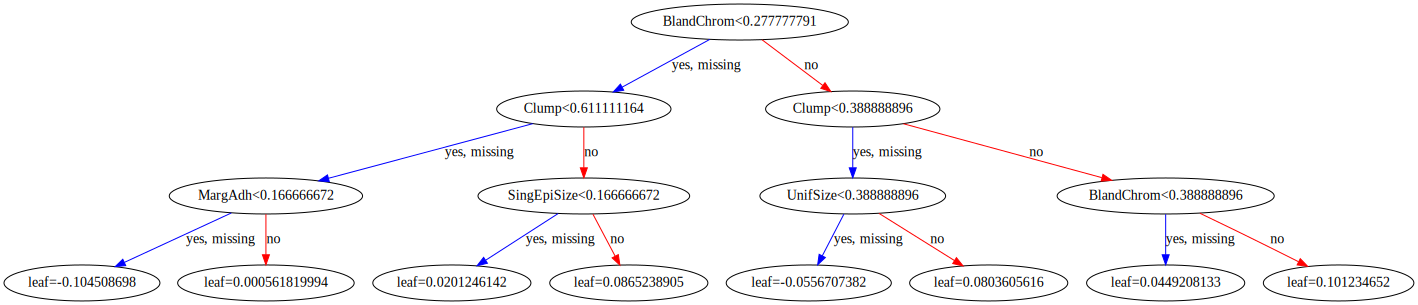

In [62]:
xgb.to_graphviz(xgbmodel,num_trees=20)

### Cross-Validation

In [63]:
cv = cross_val_score(xgbmodel,new_X,new_y,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [64]:
cv.mean()

0.9746402768502216

### Save the Model

In [65]:
filename = 'modelcell.sav'
dump(xgbmodel,open(filename,'wb'))